# Train/Loss

In [55]:
import json
import matplotlib.pyplot as plt
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from datasets import load_dataset
import torch
import numpy as np
from scipy.signal import savgol_filter

# model_dir = os.getenv('MODEL_DIR')
model_dir = "wav2vec2-large-xlsr-japlmthufiel-ipajaplmthufielta-nq-ns"
state_file = f"{model_dir}/trainer_state.json"

In [ ]:
def load_training_state(state_file):
    with open(state_file, "r") as f:
        state = json.load(f)
    return state

training_state = load_training_state(state_file)

steps_train = []
train_loss = []
learning_rate = []

for entry in training_state["log_history"]:
    if "train_loss" in entry:
        steps_train.append(entry["step"])
        train_loss.append(entry["train_loss"])
        if "learning_rate" in entry:
            learning_rate.append(entry["learning_rate"])

if not steps_train or not train_loss:
    raise ValueError("As listas de steps ou train_loss estão vazias, não há dados suficientes para o gráfico.")

if not learning_rate:
    learning_rate = [None] * len(train_loss)  

steps_train, train_loss, learning_rate = zip(*sorted(zip(steps_train, train_loss, learning_rate)))

window_length = min(5, len(train_loss))  
polyorder = min(2, window_length - 1)  

train_loss_smoothed = savgol_filter(train_loss, window_length, polyorder) 
learning_rate_smoothed = savgol_filter(learning_rate, window_length, polyorder)


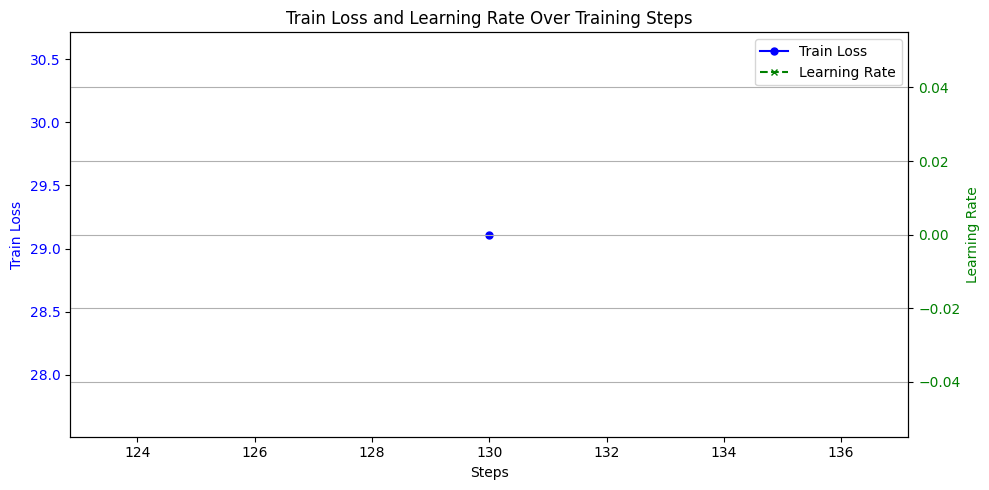

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("Steps")
ax1.set_ylabel("Train Loss", color='blue')
ax1.plot(steps_train, train_loss, label="Train Loss", marker="o", color='blue', linestyle='-', markersize=5)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel("Learning Rate", color='green')
ax2.plot(steps_train, learning_rate_smoothed, label="Learning Rate", marker="x", color='green', linestyle='--', markersize=5)
ax2.tick_params(axis='y', labelcolor='green')

plt.title("Train Loss and Learning Rate Over Training Steps")
fig.tight_layout()  
plt.grid(True)
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.show()

# Test Model

In [ ]:
def test_model_on_samples(model_dir, languages, num_samples):
    # Carregar o modelo 
    # PER (Phone Error Rate) e PFER (Phoneme-Free Error Rate)
    processor = Wav2Vec2Processor.from_pretrained(model_dir)
    model = Wav2Vec2ForCTC.from_pretrained(model_dir)
    model.eval()

    results = {}

    for lang in languages:
        print(f"\\nTesting language: {lang}")
        dataset = load_dataset("common_voice", lang, split="test")
        dataset = dataset.shuffle(seed=42).select(range(num_samples))
        
        for i, sample in enumerate(dataset):
            input_values = processor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values
            logits = model(input_values).logits
            predicted_ids = torch.argmax(logits, dim=-1)
            transcription = processor.batch_decode(predicted_ids)[0]

            print(f"Sample {i+1}: {transcription}")
            results.setdefault(lang, []).append(transcription)

    return results

In [ ]:
results = test_model_on_samples(model_dir, languages, num_samples)